In [19]:
from sklearn.model_selection import GridSearchCV
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GroupKFold
#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)


訓練データとテストデータの読み込み

In [20]:
train = pd.read_csv("../data/train.csv", index_col="id")
test = pd.read_csv("../data/test.csv", index_col="id")


In [21]:
train.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [22]:
test.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
id,,,,,,,,,,,,,,,,,,,,,,,,
26570,F,119.57,material_5,material_6,6,4,6,9,6,19.305,10.178,17.534,18.168,11.598,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
26571,F,113.51,material_5,material_6,6,4,11,8,0,17.883,11.927,17.228,16.033,11.179,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
26572,F,112.16,material_5,material_6,6,4,8,12,4,18.475,10.481,16.619,18.189,12.126,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
26573,F,112.72,material_5,material_6,6,4,8,11,10,16.518,10.888,15.293,18.592,11.304,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
26574,F,208.00,material_5,material_6,6,4,14,16,8,17.808,12.693,17.678,15.814,13.431,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044


In [23]:
#訓練データとテストデータを結合させる

#訓練データとテストデータを識別するためのtrainラベルを訓練データとテストデータに付与する
train["train"] = True
test["train"] = False

#テストデータの目的変数を適当にセットする
test["failure"] = 99999

#訓練データとテストデータを結合
train_test = train.append(test)


False
False


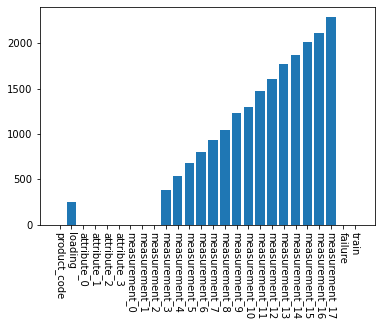

In [24]:
#欠損値がないか確認（nullが1つもなければ以下のprint文でTrueが出力される）
print(np.all(train.isnull().sum() == 0))
print(np.all(test.isnull().sum() == 0))

train_miss = train.isnull().sum()
plt.bar(train_miss.index, train_miss)
plt.xticks(rotation=270)
plt.show()


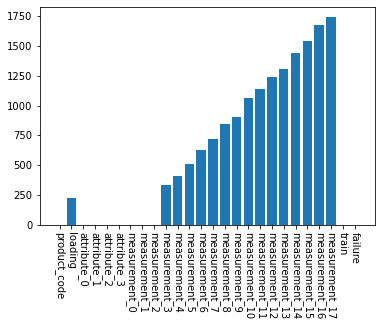

In [25]:
test_miss = test.isnull().sum()
plt.bar(test_miss.index, test_miss)
plt.xticks(rotation=270)
plt.show()


In [26]:
#欠損値補完（特徴量ごとの平均値を採用）
train_test.fillna(train_test.mean(), inplace=True)

#欠損値がないか確認（nullが1つもなければTrueが出力される）
print(np.all(train_test.isnull().sum() == 0))

True


In [27]:
#ラベルエンコーディングを実施

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_test["product_code"])
train_test["product_code"] = le.transform(train_test["product_code"])
le.fit(train_test["attribute_0"])
train_test["attribute_0"] = le.transform(train_test["attribute_0"])
le.fit(train_test["attribute_1"])
train_test["attribute_1"] = le.transform(train_test["attribute_1"])


In [28]:
#Onehotエンコーディングを実施
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False, drop='first')
col = ["attribute_0", "attribute_1", "attribute_2", "attribute_3"]
ohe.fit(train_test[col])
print(ohe.categories_)
ohe.fit(train_test[col])
print(ohe.categories_)

[array([0, 1]), array([0, 1, 2, 3]), array([5, 6, 7, 8, 9], dtype=int64), array([4, 5, 6, 7, 8, 9], dtype=int64)]
[array([0, 1]), array([0, 1, 2, 3]), array([5, 6, 7, 8, 9], dtype=int64), array([4, 5, 6, 7, 8, 9], dtype=int64)]


In [29]:
#特徴量追加

#mesurement3とmesurement5の欠損値の数
train_test['measurement_3_na'] = train_test['measurement_3'].isna().astype(int)
train_test['measurement_5_na'] = train_test['measurement_5'].isna().astype(int)

#attribute_2とattribute_3の積
train_test['attribute_2*3'] = train_test['attribute_2'] * train_test['attribute_3']

#['measurement_3', 'measurement_4', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16']の平均と分散
meas_gr1_cols = [f"measurement_{i:d}" for i in list(range(3, 5)) + list(range(9, 17))]
print(meas_gr1_cols)
train_test['meas_gr1_avg'] = np.mean(train_test[meas_gr1_cols], axis=1)
train_test['meas_gr1_std'] = np.std(train_test[meas_gr1_cols], axis=1)

#['measurement_5', 'measurement_6', 'measurement_7', 'measurement_8']の平均と分散
meas_gr2_cols = [f"measurement_{i:d}" for i in list(range(5, 9))]
print(meas_gr2_cols)
train_test['meas_gr2_avg'] = np.mean(train_test[meas_gr2_cols], axis=1)


['measurement_3', 'measurement_4', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16']
['measurement_5', 'measurement_6', 'measurement_7', 'measurement_8']


In [30]:
#訓練データとテストデータを再分割（数値データの標準化前にやっておかないといけない）

train = train_test[train_test["train"] == True]
train= train.drop(["train"], axis = 1)

test = train_test[train_test["train"] == False]
test= test.drop(["train", "failure"], axis = 1)

In [31]:
#データを標準化する列を抽出（数値変数のみ）
cols = [col for col in train.columns if train[col].dtypes == 'float64']

train[cols] = (train[cols] - train[cols].mean()) / train[cols].std(ddof=0)
test[cols] = (test[cols] - test[cols].mean()) / test[cols].std(ddof=0)


In [32]:
train

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,measurement_3_na,measurement_5_na,attribute_2*3,meas_gr1_avg,meas_gr1_std,meas_gr2_avg
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,-1.228605,1,3,9,5,7,8,4,0.249966,0.797271,-1.402872,1.815806,0.022852,1.143352,-0.777294,-0.188783,-1.062011,2.414349,-0.561228,0.021428,-1.319569,-1.087242,0.532956,0,0,0,45,-0.581121,-1.719996,0.788892
1,0,-1.105295,1,3,9,5,14,3,3,0.424014,-0.194686,0.598880,0.389606,1.049291,-1.149054,1.042797,1.334055,-0.844900,0.032516,-0.827350,-0.435072,-0.405864,-0.509723,-0.163014,0,0,0,45,-0.268776,-1.076143,0.440113
2,0,-1.168623,1,3,9,5,12,1,5,0.267069,-0.081087,-0.396404,0.743352,1.018772,-0.745405,1.316425,-0.372574,-0.091301,1.447898,0.945900,1.793880,-0.607940,0.902056,-0.321485,0,0,0,45,1.716319,-0.796378,0.306592
3,0,-0.688770,1,3,9,5,13,2,6,-0.499549,-0.551709,1.472169,0.844277,0.881439,0.035591,1.066368,0.166400,-0.532423,-1.169485,-0.363204,-0.339823,0.775037,0.430040,1.060445,0,0,0,45,-0.308771,-0.380717,1.613371
4,0,1.550629,1,3,9,5,9,2,8,1.563880,1.235436,-0.140213,-1.799138,-0.417631,-0.942677,-1.120611,0.703186,0.519313,0.498768,0.471899,-2.287897,-1.239678,-0.033438,-1.029739,0,0,0,45,-0.128794,0.622395,-1.647485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26565,4,0.801245,1,1,6,9,6,16,4,-1.499572,1.548846,0.955719,-2.044824,-0.866253,0.333017,-0.005500,-2.874170,-0.826638,-1.105748,0.125134,1.752861,0.768324,0.043155,0.236314,0,0,0,54,-0.687110,-0.174197,-0.806252
26566,4,0.468386,1,1,6,9,10,12,8,-0.250046,-0.002031,0.870322,1.597645,-0.587517,0.544453,-0.193144,-1.414055,0.946772,-1.021227,-1.080031,-1.201926,-1.244378,0.002542,1.294932,0,0,0,54,-1.743300,0.459340,1.210270
26567,4,-0.314207,1,1,6,9,1,10,1,-2.134396,-0.199757,-0.355739,0.891171,-0.088031,0.257143,-0.024047,0.232769,-1.141821,-2.106145,-0.525387,0.381145,0.396397,-1.464733,0.416433,0,0,0,54,-2.072160,-0.320268,0.351268


In [33]:
test

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,measurement_3_na,measurement_5_na,attribute_2*3,meas_gr1_avg,meas_gr1_std,meas_gr2_avg
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
26570,5,-0.207125,0,1,6,4,6,9,6,1.520347,-1.554278,0.397540,0.662282,-0.114918,-0.382481,-0.630140,-0.140888,-0.509061,1.410415,-1.578778,0.517322,-0.920774,0.686537,-0.535760,0,0,24,-0.348016,0.433461,0.283021
26571,5,-0.362737,0,1,6,4,11,8,0,0.090072,0.200249,0.090397,-1.505431,-0.540917,0.342618,0.627617,-1.394294,0.111735,0.427967,1.320470,0.431343,-0.225269,-1.602976,-1.318673,0,0,24,-0.246046,-0.784759,-0.804096
26572,5,-0.397403,0,1,6,4,8,12,4,0.685517,-1.250321,-0.520876,0.683604,0.421901,-1.276161,0.332096,0.604859,-0.498705,-0.756415,-1.804081,-0.282201,1.314393,-0.385245,-0.340118,0,0,24,-0.599934,0.287864,-0.348176
26573,5,-0.383023,0,1,6,4,8,11,10,-1.282872,-0.842035,-1.851826,1.092779,-0.413829,-0.083911,0.380156,1.338800,-1.743272,-0.736751,-0.176727,-0.333641,-1.675471,-0.328134,-0.859204,0,0,24,-1.697990,-0.690117,-0.637432
26574,5,2.063631,0,1,6,4,14,16,8,0.014635,0.968670,0.542077,-1.727787,1.748699,0.112089,0.973245,-1.013878,-0.652092,0.025610,0.256372,0.045545,-1.201935,0.331180,0.799641,0,0,24,-0.349458,-1.473109,0.338745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47340,8,0.439205,1,0,9,5,0,4,9,0.675459,0.845281,1.011824,-0.433251,-0.515499,-0.464741,0.278922,-0.002194,0.591827,-0.261032,1.151493,-0.727523,0.065982,-0.057431,-0.039462,0,0,45,0.693083,-0.261491,-0.194176
47341,8,-1.363687,1,0,9,5,4,8,7,1.112990,-1.837170,1.154354,-0.002785,0.036571,-1.130938,-0.448123,-0.063493,-2.046809,1.253102,-0.182055,-0.606272,-0.873689,-0.080653,-0.707171,0,0,45,-1.263383,-0.601537,0.035289
47342,8,-1.538301,1,0,9,5,10,11,2,0.867570,0.002570,1.108182,0.400329,0.376150,0.608691,-1.004399,0.008655,1.136123,-0.584733,0.598131,-0.437990,-0.629523,0.697959,0.657662,0,0,45,0.296189,1.171680,1.250080


In [ ]:
auc_list = []
test_pred_list = []
importance_list = []
kf = GroupKFold(n_splits=5)   # grouped by product_code


In [142]:
#訓練データの分割
train_label = train["failure"]
train = train.drop(["failure"], axis=1)
train_X, val_X, train_Y, val_Y = train_test_split(
    train, train_label, test_size=0.1, random_state=42, stratify=train_label)

In [143]:

# チューニングモデル
logreg = LogisticRegression()

param_grid = {'C': [0.0001, 0.001, 0.01, 0.05 ,0.1, 0.5, 1],
                 'penalty':['l2','l1'],
                 'solver': ['lbfgs', 'sag', 'newton-cg', 'liblinear']}  
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
logreg_cv.fit(train_X, train_Y)
print(logreg_cv.best_params_)


c:\Users\keisu\anaconda3\envs\myenv2\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\keisu\anaconda3\envs\myenv2\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\keisu\anaconda3\envs\myenv2\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\keisu\anaconda3\envs\myenv2\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
c:\Users\keisu\anacon

{'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}


In [144]:
from sklearn.metrics import classification_report
predicted = logreg_cv.predict(val_X)
print(classification_report(val_Y, predicted))


              precision    recall  f1-score   support

           0       0.79      1.00      0.88      2092
           1       0.00      0.00      0.00       565

    accuracy                           0.79      2657
   macro avg       0.39      0.50      0.44      2657
weighted avg       0.62      0.79      0.69      2657



In [145]:
pred_y = logreg_cv.predict_proba(test)[:, 1]
pred_y


array([0.22626233, 0.18558803, 0.20924028, ..., 0.17644424, 0.25152409,
       0.19644711])

In [146]:
submission = pd.read_csv("../submission/sample_submission.csv")
submission["failure"] = pred_y
submission.to_csv("../submission/submission.csv", index=False)
